In [111]:
import sys, os, h5py
import numpy as np
import tensorflow as tf
# from rich.console import Console
# console = Console()

sys.path.append(r"/Users/sachagreenfield/Desktop/GitHub/")
from qnl_trajectories.analysis import data_analysis
from utils import *
from vanilla_lstm import *

dark_mode_compatible(dark_mode_color=r'#86888A')

In [306]:
filepath = "data_sim"
file_prefix = "test_data_3"

filepath + "/" + file_prefix + "X" + ".h5"

'data_sim/test_data_3X.h5'

In [307]:
dX = dict()
dY = dict()
dZ = dict()

for label in ["X","Y","Z"]:
    d = dict()
    f = h5py.File(filepath + "/" + file_prefix + label + ".h5", 'r')

    # PARAMETERS    
    N_tg = f["parameters"]["N_time_groups"][()]
    strong_ro_dt = f["parameters"]["sro_Δt"][()]
    N_reps = f["parameters"]["N_reps"][()]
    dt = f["parameters"]["integration_time"][()]
    
    for t in range(1,N_tg+1):
        d[f't_{t}'] = dict()
        
        d[f't_{t}']['N_reps'] = N_reps
        d[f't_{t}']['integration_time'] = dt
        
        d[f't_{t}']['Tm'] = f[f't_{t}']['Tm'][()]
        d[f't_{t}']['I'] = np.transpose(f[f't_{t}']['I'][()])
        d[f't_{t}']['Q'] = np.transpose(f[f't_{t}']['Q'][()])
        d[f't_{t}']['strong_ro_classifications'] = f[f't_{t}']['strong_ro_classifications'][()].astype(int)

    print(label)
    if label=="X":
        dX = d
    elif label=="Y":
        dY = d
    elif label=="Z":
        dZ = d
        
    

X
Y
Z


In [308]:
dX['t_1']['strong_ro_classifications']

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1])

In [309]:
# NOTE: Note that most of the settings below must be equal to the settings in prep.py
# Path that contains the training/validation dataset.

# last_timestep determines the length of trajectories used for training in units of strong_ro_dt.
# Must be <= the last strong readout point
last_timestep = N_tg
mask_value = -1 # This is the mask value for the data, not the missing labels
num_features = 2 # I and Q

# console.print("Loading data...", style="bold red")

# Load the data from the pickle files.
# dX = data_analysis.load_data(os.path.join(filepath, 'meas_X'), last_timestep=last_timestep, qubit='Q6')
# dY = data_analysis.load_data(os.path.join(filepath, 'meas_Y'), last_timestep=last_timestep, qubit='Q6')
# dZ = data_analysis.load_data(os.path.join(filepath, 'meas_Z'), last_timestep=last_timestep, qubit='Q6')


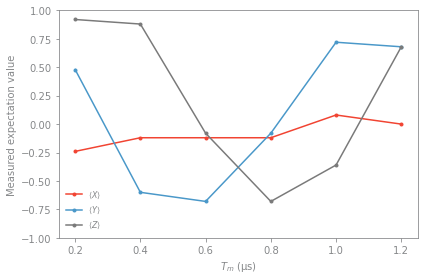

In [310]:
# Get the expectation value from the data containers for each measurement axis.
Tm, expX, expY, expZ = data_analysis.plot_average_trajectories(dX, dY, dZ,
                                                               timesteps=np.arange(1, last_timestep+1),
                                                               fit_curves=[],
                                                               artificial_detuning=False,
                                                               savepath=None)


In [311]:
expX = np.array(expX)
expY = np.array(expY)
expZ = np.array(expZ)

# dt = f["parameters"]["integration_time"][()]
timesteps = range(1, last_timestep+1)
tfinal = dZ[f't_{timesteps[-1]}']['Tm']

In [312]:


print("Loaded data...")

# Extract the I and Q voltage records and apply a scaling
scaling = 500
rawX_I, rawX_Q, labelsX, reps_per_timestepX = get_data(dX, 'X', timesteps, scaling=scaling)
rawY_I, rawY_Q, labelsY, reps_per_timestepY = get_data(dY, 'Y', timesteps, scaling=scaling)
rawZ_I, rawZ_Q, labelsZ, reps_per_timestepZ = get_data(dZ, 'Z', timesteps, scaling=scaling)

Loaded data...


In [313]:
# Append I and Q voltage records from different measurement axes
raw_I = rawX_I + rawY_I + rawZ_I
raw_Q = rawX_Q + rawY_Q + rawZ_Q
reps_per_timestep = reps_per_timestepX + reps_per_timestepY + reps_per_timestepZ
labels = np.vstack((np.vstack((labelsX, labelsY)), labelsZ))
meas_ax = ['X'] * np.sum(reps_per_timestepX) + ['Y'] * np.sum(reps_per_timestepY) + \
          ['Z'] * np.sum(reps_per_timestepZ)


In [318]:

# By default, this will pad using 0s; it is configurable via the "value" parameter.
# Note that you could "pre" padding (at the beginning) or "post" padding (at the end).
# We recommend using "post" padding when working with RNN layers (in order to be able to use the
# CuDNN implementation of the layers).
padded_I = tf.keras.preprocessing.sequence.pad_sequences(raw_I, padding='post',
                                                         dtype='float32', value=mask_value)
padded_Q = tf.keras.preprocessing.sequence.pad_sequences(raw_Q, padding='post',
                                                         dtype='float32', value=mask_value)


In [319]:

batch_size, sequence_length = np.shape(padded_I)

# Pad the labels such that they can be processed by the NN later
padded_labels = pad_labels(labels, (int(strong_ro_dt/dt) * np.array(timesteps)).tolist() * 3, reps_per_timestep, mask_value)


In [320]:

# Split validation and data deterministically so we can compare results from run to run
train_x, train_y, valid_x, valid_y = split_data_same_each_time(padded_I.astype(np.float32), padded_Q.astype(np.float32),
                                                               padded_labels, 0.90, start_idx=0)


Training batch size: 810 (90.0%)
Validation batch size: 90 (10.0%)


In [321]:

train_msk = train_x != mask_value
valid_msk = valid_x != mask_value
all_data_msk = padded_I != mask_value

all_time_series_lengths = np.sum(all_data_msk, axis=1)
valid_time_series_lengths = np.sum(valid_msk[:, :, 0], axis=1)
train_time_series_lengths = np.sum(train_msk[:, :, 0], axis=1)

# Save a pre-processed file as an h5 file. Note these files can be quite large, typ. 15 GB.
print(f"Saving processed data to {filepath}...")
with h5py.File(os.path.join(filepath, "training_validation_split.h5"), 'w') as f:
    f.create_dataset("train_x", data=train_x)
    f.create_dataset("train_y", data=train_y)
    f.create_dataset("valid_x", data=valid_x)
    f.create_dataset("valid_y", data=valid_y)

    f.create_dataset("Tm", data=Tm[np.array(timesteps)-1])
    f.create_dataset("expX", data=expX[np.array(timesteps)-1])
    f.create_dataset("expY", data=expY[np.array(timesteps)-1])
    f.create_dataset("expZ", data=expZ[np.array(timesteps)-1])

    f.create_dataset("all_time_series_lengths", data=all_time_series_lengths)
    f.create_dataset("valid_time_series_lengths", data=valid_time_series_lengths)
    f.create_dataset("train_time_series_lengths", data=train_time_series_lengths)

    f.create_dataset("dt", data=np.array([dt]))
    f.create_dataset("tfinal", data=np.array([tfinal]))

Saving processed data to data_sim...
